# Load & Transform Data

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

# Import data and keep price values
data = pd.read_csv('C:/Users/Patrick/Documents/projects/InflationDecomposition/data/HFCE2000-2024.csv')
data['date'] = pd.to_datetime(data['REF_DATE'])
price_df = data.loc[data['Prices'] == 'Current prices']

# Transform data into price index for each column 
date_mask = price_df['REF_DATE'] == '2017-01'
price_df['price'] = price_df.groupby('Estimates')['VALUE'].transform( lambda x: x / x[date_mask].iloc[0] * 100)
prices = price_df.pivot(index= 'date', columns = 'Estimates', values = 'price')
prices = prices.dropna(axis='columns')

# prices.columns = prices.columns.values + '_p'
ln_prices = prices.apply(lambda x: np.log(x))

quantity_df = data.loc[data['Prices'] == '2017 constant prices']
date_mask = quantity_df['REF_DATE'] == '2017-01'
quantity_df['quantity'] = quantity_df.groupby('Estimates')['VALUE'].transform( lambda x: x / x[date_mask].iloc[0] * 100)
quantities = quantity_df.pivot(index= 'date', columns = 'Estimates', values = 'quantity')
quantities = quantities.dropna(axis='columns')
quantities.columns = quantities.columns.values + '_q'

ln_quantities = quantities.apply(lambda x: np.log(x))

C:\Users\Patrick\AppData\Local\Temp\ipykernel_32664\1973289926.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['price'] = price_df.groupby('Estimates')['VALUE'].transform( lambda x: x / x[date_mask].iloc[0] * 100)
C:\Users\Patrick\AppData\Local\Temp\ipykernel_32664\1973289926.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantity_df['quantity'] = quantity_df.groupby('Estimates')['VALUE'].transform( lambda x: x / x[date_mask].iloc[0] * 100)


# Define functions

In [2]:
def rolling_var_regression(df):
    resid_results = []
    window = 0
    while window+40 <= len(df):
        model_df = df.iloc[window:window+40,:]
        model = VAR(model_df)
        varmodel = model.fit(4)
        # Access the residuals from the fitted VAR model
        residuals = varmodel.resid
        resid_results.append(label_residuals(residuals))
        window = window + 1
    return resid_results


def label_residuals(df):
    std_error_residuals = df.std()

    # Calculate the t-statistic for each residual by dividing the residuals by their standard error
    t_statistics = df / std_error_residuals
    threshold = 0.25

    # Label residuals as "ambiguous" if their t-statistics are less than 0.125
    ambiguous_labels = np.abs(t_statistics) < threshold

    if ambiguous_labels.iloc[-1,].all():
        label = "A"
        return label  

    # Check if all values in both columns are positive or negative
    if np.all(df.iloc[-1:, :].values[0] > 0):
        label = "D"
    elif np.all(df.iloc[-1:, :].values[0] < 0):
        label = "D"
    else:
        label = "S"

    
    return label  

# Rolling Regressions: 10-year period

In [3]:
counter = 0
residuals_results = []
for i in range(0,len(prices.columns)):
    rolling_df = pd.concat([ln_quantities.iloc[:,counter], ln_prices.iloc[:,counter]],axis=1 )
    residuals_results.append(rolling_var_regression(rolling_df))
    counter = counter + 1

c:\Users\Patrick\Documents\projects\ml\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\Patrick\Documents\projects\ml\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\Patrick\Documents\projects\ml\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\Patrick\Documents\projects\ml\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
c:\Users\Patrick\Documents\projects\ml\venv\lib\site-packages\statsmodels\tsa\base\t

In [4]:
residuals_results
label_df = pd.DataFrame(residuals_results).T
label_df.columns = ln_prices.columns
label_df.index = ln_prices.index[-len(residuals_results[0]):]
label_df.shape


(59, 99)

# Calculate Inflation

Weight by Nom. Price Contribution to HFCE Inflation

In [5]:
# Get Current Price DF to calculate weights
hfce_nom =  price_df.pivot(index= 'date', columns = 'Estimates', values = 'VALUE').dropna(axis='columns')

# Get Overall HCFE inflation rate to account for dropped NA columns
data = pd.read_csv('C:/Users/Patrick/Documents/projects/InflationDecomposition/data/HFCE_Total.csv')
data['date'] = pd.to_datetime(data['REF_DATE'])
inflation = pd.DataFrame()
inflation['real'] = data.loc[data['Prices'] == '2017 constant prices']['VALUE'].values
inflation['nom'] = data.loc[data['Prices'] == 'Current prices']['VALUE'].values
inflation.set_index(hfce_nom.index)
inflation['hfce_index'] = inflation['nom'] / inflation['real'] * 100 
inflation['hfce_inflation'] = inflation['hfce_index'].pct_change(4)
inflation


,real,nom,hfce_index,hfce_inflation
0,181096,143884,79.451782,NaN
1,182693,145903,79.862392,NaN
2,185049,148957,80.495977,NaN
3,185287,150284,81.108766,NaN
4,186897,151594,81.110986,0.020883
...,...,...,...,...
93,333835,386263,115.704764,0.032642
94,333968,389176,116.530925,0.032747
95,336611,395315,117.439715,0.029790
96,339762,400554,117.892525,0.027229


In [6]:
# Create weights
hfce_nom = hfce_nom.reset_index(drop=True)
inflation = inflation.reset_index(drop=True)

weights =  hfce_nom.div(inflation['nom'], axis=0)


# Create empty dataframe to fill 
raw_labeled_hfce = pd.DataFrame(columns=['Demand', 'Supply', 'Ambiguous'])

# For each row, sum by category. E.g. if element [1,1] of label_df is S, sum in S cateogry. 
for i, (values, categories) in enumerate(zip(weights.iterrows(), label_df.iterrows())):
    values = values[1]  # Extract the row data
    categories = categories[1]  # Extract the row categories
    
    # Calculate the sum for each category
    sum_A = values[categories == 'A'].sum()
    sum_S = values[categories == 'S'].sum()
    sum_D = values[categories == 'D'].sum()
    
    # Assign the sums to the respective columns in the output DataFrame
    raw_labeled_hfce.loc[i] = [sum_D, sum_S, sum_A]

shaped_df = inflation['hfce_inflation'].iloc[-raw_labeled_hfce.shape[0]:].reset_index()
final_df = raw_labeled_hfce.mul(shaped_df['hfce_inflation'],axis = 0)
final_df.index = ln_prices.iloc[-final_df.shape[0]:].index



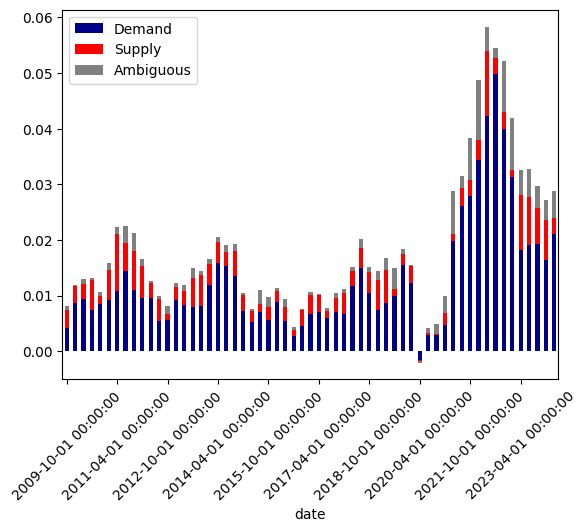

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Separate into positive and negative values
df_positive = final_df.clip(lower=0)
df_negative = final_df.clip(upper=0)

# Plot stacked bar chart with separate positive and negative values
ax = df_positive.plot(kind='bar', stacked=True, color=['darkblue', 'red', 'gray'])
df_negative.plot(kind='bar', stacked=True, color=['darkblue', 'red', 'gray'], ax=ax, legend = False)
plt.xticks(ticks=range(0, len(df_positive), 6), rotation=45)  # Adjust interval as needed
import matplotlib.dates as mdates
# myFmt = mdates.DateFormatter('%Y-%m-%d')
# ax.xaxis.set_major_formatter(myFmt)

plt.show()

In [9]:
final_df

,Demand,Supply,Ambiguous
date,,,
2009-10-01,0.004179,0.003316,0.000661
2010-01-01,0.008603,0.003165,0.000053
2010-04-01,0.009349,0.002778,0.000812
2010-07-01,0.007352,0.005445,0.000399
2010-10-01,0.008400,0.001443,0.000796
2011-01-01,0.009129,0.005546,0.001102
2011-04-01,0.010850,0.010263,0.001138
2011-07-01,0.014374,0.005112,0.003097
2011-10-01,0.010984,0.007067,0.003194
